In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import metrics
from scipy import stats
import statsmodels.api as sm
import math
import re
import sys
import pandas.core.algorithms as algos
pd.pandas.set_option('display.max_columns',None)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
train=pd.read_csv('kaggle-train.csv')
train.head()

In [3]:
train.shape

(20800, 5)

In [4]:
features=[i for i  in train.columns if i not in ['label']]
features

['id', 'title', 'author', 'text']

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [6]:
train.fillna('unavailable',inplace=True)

In [7]:
test=pd.read_csv('kaggle-test.csv')
test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [61]:
test.shape

(5200, 4)

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5200 entries, 0 to 5199
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5200 non-null   int64 
 1   title   5078 non-null   object
 2   author  4697 non-null   object
 3   text    5193 non-null   object
dtypes: int64(1), object(3)
memory usage: 162.6+ KB


In [9]:
test.fillna('unavailable',inplace=True)

In [10]:
df=pd.concat([train,test],axis='rows')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26000 entries, 0 to 5199
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      26000 non-null  int64  
 1   title   26000 non-null  object 
 2   author  26000 non-null  object 
 3   text    26000 non-null  object 
 4   label   20800 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 1.2+ MB


In [12]:
df['comb']=df['author']+"_"+df['title']

In [13]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to C:\Users\ROMAK
[nltk_data]     DAS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\ROMAK
[nltk_data]     DAS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
import string
import re
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [15]:
wordnet=WordNetLemmatizer()
stemmer=PorterStemmer()
def clean(text):
    # text="".join([char for char in text if char not in string.punctuation])
    text="".join([re.sub('[^a-zA-Z]',' ',char) for char in text ])
    text=text.lower()
    text=text.split()
    text=[stemmer.stem(word) for word in text if word not in set(stopwords.words("english"))]
    text=" ".join(text)
    return text

In [16]:
df['comb']=df['comb'].apply(clean)

In [17]:
df.head()

,id,title,author,text,label,comb
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1.0,darrel lucu hous dem aid even see comey letter...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0.0,daniel j flynn flynn hillari clinton big woman...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1.0,consortiumnew com truth might get fire
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1.0,jessica purkiss civilian kill singl us airstri...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1.0,howard portnoy iranian woman jail fiction unpu...


In [18]:
import tensorflow
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Bidirectional

In [19]:
voc_size=30000   # Vocabulary size

In [20]:
title=df['comb']
title[0]

0    darrel lucu hous dem aid even see comey letter...
0    david streitfeld specter trump loosen tongu pu...
Name: comb, dtype: object

In [21]:
one_hot_r=[one_hot(words, voc_size) for words in title]

In [22]:
one_hot_r[0:2]

[[26135,
  26921,
  28977,
  20613,
  19570,
  23018,
  25987,
  14851,
  16149,
  8523,
  23997,
  26153],
 [11422, 28691, 2076, 2076, 27235, 17593, 23472, 17458, 7711, 6640]]

In [23]:
sent_len=50
embedded_docs=pad_sequences(one_hot_r,padding='post',maxlen=sent_len)

In [24]:
embedded_docs[:10]

array([[26135, 26921, 28977, 20613, 19570, 23018, 25987, 14851, 16149,
         8523, 23997, 26153,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0],
       [11422, 28691,  2076,  2076, 27235, 17593, 23472, 17458,  7711,
         6640,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0],
       [27235,  2565, 21617,  2219, 22303, 29737,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,    

In [25]:
sgd=tensorflow.keras.optimizers.SGD(learning_rate=0.01,momentum=0.9, nesterov=True)
rms = tensorflow.keras.optimizers.RMSprop()
nadam=tensorflow.keras.optimizers.Nadam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam"
)

In [26]:
embedding_vector_features=50
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_len))
# model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(100)))  # used Bidirectional LSTM
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer=nadam,metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            1500000   
                                                                 
 bidirectional (Bidirectiona  (None, 200)              120800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 1,621,001
Trainable params: 1,621,001
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
len(embedded_docs)

26000

In [28]:
X=embedded_docs[:train.shape[0]]
y=df['label'][:train.shape[0]]
x_test=embedded_docs[train.shape[0]:]

In [29]:
X_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
traininglog=model.fit(X_train, y_train, validation_data=(x_valid, y_valid), epochs=10, batch_size=32)

Epoch 1/10
520/520 [==============================] - 15s 17ms/step - loss: 0.1562 - accuracy: 0.9367 - val_loss: 0.0373 - val_accuracy: 0.9882
Epoch 2/10
520/520 [==============================] - 8s 16ms/step - loss: 0.0140 - accuracy: 0.9963 - val_loss: 0.0296 - val_accuracy: 0.9925
Epoch 3/10
520/520 [==============================] - 8s 16ms/step - loss: 0.0042 - accuracy: 0.9991 - val_loss: 0.0411 - val_accuracy: 0.9885
Epoch 4/10
520/520 [==============================] - 8s 16ms/step - loss: 0.0031 - accuracy: 0.9993 - val_loss: 0.0263 - val_accuracy: 0.9925
Epoch 5/10
520/520 [==============================] - 8s 16ms/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 0.0343 - val_accuracy: 0.9923
Epoch 6/10
520/520 [==============================] - 8s 16ms/step - loss: 2.4344e-04 - accuracy: 1.0000 - val_loss: 0.0354 - val_accuracy: 0.9925
Epoch 7/10
520/520 [==============================] - 8s 16ms/step - loss: 1.2049e-04 - accuracy: 1.0000 - val_loss: 0.0387 - val_accurac

Text(0.5, 1.0, 'Kaggle Fake News')

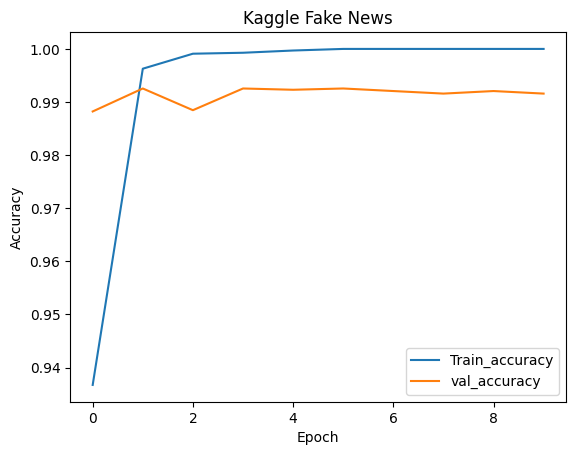

In [31]:
plt.plot(traininglog.history['accuracy'], label='Train_accuracy')
plt.plot(traininglog.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Kaggle Fake News')

In [32]:
y_pred_prob=np.array(model.predict(X_train))[:,0]
y_pred_valid=np.array(model.predict(x_valid))[:,0]
y_pred=np.array(model.predict(x_test))[:,0]

163/163 [==============================] - 1s 5ms/step


In [33]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_valid, y_pred_valid)

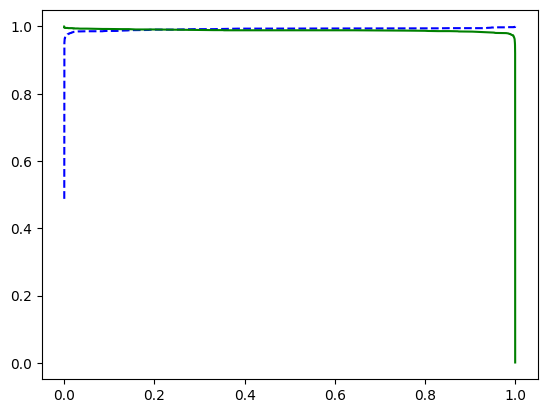

In [34]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
[...]
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

_Decision boundary to identify classes_


In [35]:
A=[]
B=[]
C=[]
for i in range(len(thresholds)):
    predicted = pd.DataFrame()
    predicted["label"] = y_pred_prob
    predicted["label"] = np.where(predicted["label"] > float(thresholds[i]), 1, 0)
    pred_valid = pd.DataFrame()
    pred_valid["label"] = y_pred_valid
    pred_valid["label"] = np.where(pred_valid["label"] > float(thresholds[i]), 1, 0)
    A.append(metrics.accuracy_score(y_train, predicted))
    B.append(metrics.accuracy_score(y_valid, pred_valid))
    C.append(thresholds[i])
acc=pd.DataFrame(C,columns=['threshold'])
acc['train_acc']=A
acc['test_acc']=B
acc.sort_values(by='test_acc',ascending=False,inplace=True)

In [36]:
acc.head()

,threshold,train_acc,test_acc
2141,0.711797,1.0,0.991587
2139,0.384734,1.0,0.991587
2142,0.744412,1.0,0.991346
2140,0.642464,1.0,0.991346
2138,0.373238,1.0,0.991346


In [37]:
cutoff=acc.iloc[0,0]
cutoff

0.71179694

In [60]:
predicted = pd.DataFrame()
predicted["label"] = y_pred_prob
predicted["label"] = np.where(predicted["label"] > float(cutoff), 1, 0)
predicted

pred_valid = pd.DataFrame()
pred_valid["label"] = y_pred_valid
pred_valid["label"] = np.where(pred_valid["label"] > float(cutoff), 1, 0)
pred_valid

predictions = pd.DataFrame()
predictions['label'] = y_pred
predictions['label'] = np.where(predictions['label'] > float(cutoff), 1, 0)
predictions

,label
0,0
1,1
2,1
3,0
4,1
...,...
5195,0
5196,0
5197,0
5198,1


In [39]:
from sklearn.metrics import roc_auc_score

_Performance on training set_


In [40]:
conf_matrix = metrics.confusion_matrix(y_train, predicted)
print(conf_matrix)
acc_train = metrics.accuracy_score(y_train, predicted)
print('Accuracy: ',acc_train)
precision_train = metrics.precision_score(y_train, predicted)
print('Presicion: ',precision_train)
sensitivity_train = metrics.recall_score(y_train, predicted)
print('Recall: ',sensitivity_train)
specificity_train = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1])
print('Specificity: ',specificity_train)
roc_auc_score(y_train, predicted)

[[8255    0]
 [   0 8385]]
Accuracy:  1.0
Presicion:  1.0
Recall:  1.0
Specificity:  1.0


1.0

<function matplotlib.pyplot.show(close=None, block=None)>

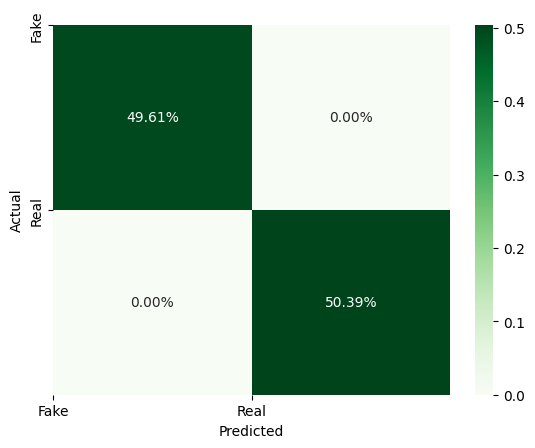

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

labels = ['Fake','Real']
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%',cmap='Greens')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.xticks(ticks=range(len(labels)), labels=labels)
plt.yticks(ticks=range(len(labels)), labels=labels)

plt.show

_Performance on testing(validation) set_


In [42]:
conf_matrix = metrics.confusion_matrix(y_valid, pred_valid)
print(conf_matrix)

acc_train = metrics.accuracy_score(y_valid, pred_valid)
print('Accuracy: ',acc_train)
precision_train = metrics.precision_score(y_valid, pred_valid)
print('Precision: ',precision_train)
sensitivity_train = metrics.recall_score(y_valid, pred_valid)
print('Recall: ',sensitivity_train)
specificity_train = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1])
print('Specificity: ',specificity_train)
roc_auc_score(y_valid, pred_valid)

[[2121   11]
 [  24 2004]]
Accuracy:  0.9915865384615384
Precision:  0.9945409429280397
Recall:  0.9881656804733728
Specificity:  0.9948405253283302


0.9915031029008515

<Axes: >

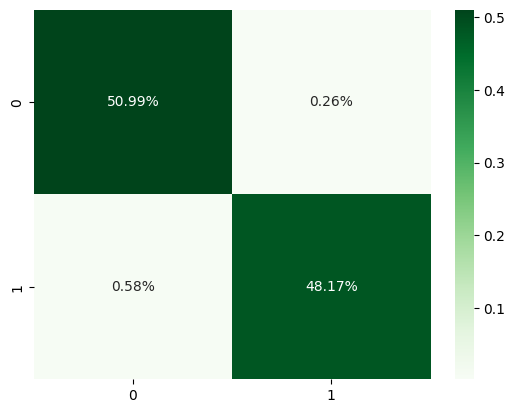

In [43]:
import seaborn as sns
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%',cmap='Greens')

In [44]:
from sklearn.metrics import f1_score
print(f1_score(y_train, predicted,average='macro'))
f1_score(y_valid, pred_valid,average='macro')

1.0


0.9915798780134827

In [49]:
pred_valid_text = pred_valid.values  # Convert to NumPy array
y_valid_text = y_valid.values  # Convert to NumPy array

misclassified_indices = np.where(pred_valid_text != y_valid_text)[0]
#misclassified_indices = np.where(pred_valid!=y_valid)[0]

In [ ]:
print("Misclassified Fake News:")
for idx in misclassified_indices:
    if idx < len(y_valid) and y_valid[idx] == 1:
        print(df['text'].iloc[idx])
        print('---')



In [ ]:
print("Misclassified Real News:")
for idx in misclassified_indices:
    if idx < len(y_valid) and y_valid[idx] == 1:
        print(df['text'].iloc[idx])
        print('---')